In [5]:
import os
import re
import operator
import unidecode
from bs4 import BeautifulSoup
import json, csv

import plotly.plotly as py
import plotly.graph_objs as go

In [8]:
titles_dataset = []
n_authors_per_paper = dict()
authors_dataset = dict()
institution_dataset = dict()


datasetFolderName = "data/" 
fileName = datasetFolderName + "raw_data.txt"

In [ ]:
def remove_empty_lines(fileName):
    if not os.path.isfile(fileName):
        print("{} does not exist ".format(fileName))
        return
    with open(fileName) as filehandle:
        lines = filehandle.readlines()

    with open(fileName, 'w') as filehandle:
        lines = filter(lambda x: x.strip(), lines)
        filehandle.writelines(lines)   

remove_empty_lines(fileName)

In [6]:
def fill_datasets(fileName):
	with open(fileName, 'r') as file:
		for paper in file:
			soup = BeautifulSoup(paper, features="html.parser")
			titles_dataset.append( soup.b.get_text() )
			list_authors = soup.i.get_text().split('· ')
			number_authors = len(list_authors )

			if number_authors not in n_authors_per_paper:
				n_authors_per_paper[number_authors] = 1
			else:
				n_authors_per_paper[number_authors] += 1

			tmp_institution_set = set()
			for i in range( number_authors ):
				author_afiliation = list_authors[i].split(" (")
				tmp_author = author_afiliation[0][0:]
				tmp_author = unidecode.unidecode(tmp_author)

				if tmp_author not in authors_dataset:
					authors_dataset[tmp_author] = 1
				else:
					authors_dataset[tmp_author] += 1

				tmp_institution = author_afiliation[1].rstrip(") ").rstrip(")").replace('"', '')

				# some authors have not updated their institution
				# if tmp_institution == '':
				# 	print(list_authors)
				# clearing some blank spaces at the end of each instituion, removing
				# accents and making strings case insensitive
				tmp_institution = tmp_institution.rstrip()
				tmp_institution = tmp_institution.lstrip()
				tmp_institution = unidecode.unidecode(tmp_institution).lower()
				tmp_institution_set.add(tmp_institution)
				# if  tmp_institution not in institution_dataset:
				# 	institution_dataset[tmp_institution] = 1
				# else:
				# 	institution_dataset[tmp_institution] += 1
			for i in tmp_institution_set:

				if  i not in institution_dataset:
					institution_dataset[i] = 1
				else:
					institution_dataset[i] += 1

In [7]:
def save_datasets_to_file():
	tmp = sorted(institution_dataset.items(), key=operator.itemgetter(1),reverse=True)
	with open(datasetFolderName+'institution_dataset.csv', 'w') as f:
		for key in tmp:
			f.write("%s;%s\n"%(key[0], key[1]))
	f.close()
	json1 = json.dumps(sorted(n_authors_per_paper.items(), key=operator.itemgetter(0)))
	json2 = json.dumps(sorted(authors_dataset.items(), key=operator.itemgetter(1),reverse=True))
	json3 = json.dumps(sorted(institution_dataset.items(), key=operator.itemgetter(1),reverse=True))
	f1 = open(datasetFolderName + "n_authors_per_paper.json","w")
	f2 = open(datasetFolderName + "authors_dataset.json","w")
	f3 = open(datasetFolderName + "institution_dataset.json","w")
	f1.write(json1)
	f2.write(json2)
	f3.write(json3)
	f1.close()
	f2.close()
	f3.close()

In [9]:
fill_datasets(fileName)
save_datasets_to_file()

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

from IPython.display import Image

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

In [13]:
n_authors_fileDir = "data/n_authors_per_paper.json"
institution_fileDir = "data/institution_dataset.json"
authors_fileDir = "data/authors_dataset.json"

In [16]:
with open(n_authors_fileDir) as handle:
    n_authors_per_paper = json.loads(handle.read())

trace0 = go.Bar(
            x = [x[0] for x in n_authors_per_paper],
            y = [y[1] for y in n_authors_per_paper],
            text=[y[1] for y in n_authors_per_paper],
            textposition = 'auto',
            name='Number of authors per paper',
            marker=dict(
                color='rgb(49,130,189)'
            )
    )

data = [trace0]


layout = go.Layout(
    title=go.layout.Title(
        text='Number of Authors per Paper',
#         xref='paper'
    ),
    xaxis=go.layout.XAxis(
        tickangle=0,
        title=go.layout.xaxis.Title(
            text='Number of authors',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Papers with N Authors',
            font=dict(
#                 family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)

init_notebook_mode(connected=True)

fig = go.Figure(data=data, layout=layout)

static_image_bytes = pio.to_image(fig, format='png')
Image(static_image_bytes)

pio.write_image(fig, file='imgs/authors_per_paper.png', format='png')

In [17]:
with open(authors_fileDir) as handle:
    authors_dataset = json.loads(handle.read())

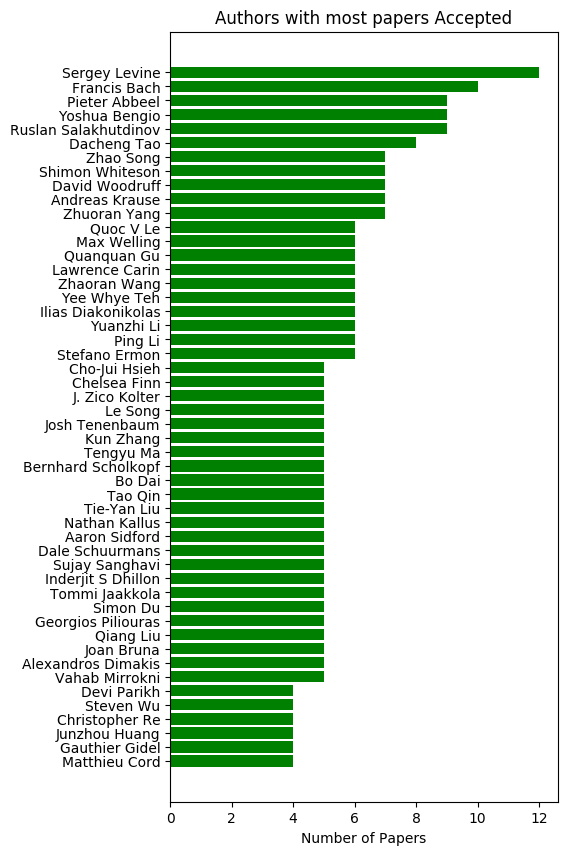

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()

fig, ax = plt.subplots(figsize=(5, 10))

nTop = 50

nPapers = [x[1] for x in authors_dataset[:nTop]]
people = [x[0] for x in authors_dataset[:nTop]]

ax.barh(people, nPapers, align='center',
        color='green', ecolor='black')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Papers')
ax.set_title('Authors with most papers Accepted')

plt.show()
# plt.savefig('authors_rank_by_accepted_papers.png', bbox_inches='tight')

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import csv

fileDir = "data/institution_dataset.csv"

institutions = []

with open(fileDir, mode='r') as csv_file:
    for line in csv_file:
        institutions.append( line.rstrip().split(";") )
csv_file.close()

institutions.sort(key=lambda x: int(x[1]), reverse=True)

print(institutions[:25])

ValueError: invalid literal for int() with base 10: ' scs, university of chinese academy of sciences'

In [22]:
plt.rcdefaults()
fig, ax = plt.subplots()
nTop = 25

nPapers = [int(x[1]) for x in institutions[:nTop]]
institutionNames = [x[0].title() for x in institutions[:nTop]]

ax.barh(institutionNames, nPapers, align='center',
        color='green', ecolor='black')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Papers')
ax.set_title('Authors with most papers Accepted')

# plt.show()
plt.savefig('institutions_ranked_by_accepted_papers.png', bbox_inches='tight')